# Import

In [2]:
import glob
import os

import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Input Data

In [4]:
def read_image_array(image_path):
    im = Image.open(image_path).convert('L')
    im_data = np.asarray(im).ravel()
    im_data = im_data
    return im_data

def read_image_list(image_path):
    im = Image.open(image_path).convert('L')
    im_data = list(im.getdata())
    return im_data

def plot_image(image_array):
    plt.figure()
    plt.imshow(image_array.reshape(256, -1), cmap=plt.get_cmap('gray'))

In [30]:
pixels = 256 * 256
data_limit = 15000

In [31]:
label_train_data = pd.read_csv(os.getcwd() + '\\..\\data\\train.csv', index_col='id')
label_test_data = pd.read_csv(os.getcwd() + '\\..\\data\\test.csv', index_col='id')

In [32]:
image_train_file_list = glob.glob(os.getcwd() + '\\..\\data\\train\\' + "*.jpg")
image_train_data = []
for index, image_path in enumerate(image_train_file_list):
    image_name = image_path.split('\\')[-1]
    data = [image_path.split('\\')[-1]] + read_image_list(image_path) + [label_train_data.loc[image_name.split('.')[0]]['landmark_id']]
    image_train_data.append(data)

    if (data_limit > 0 or data_limit is not False) and index + 1 >= data_limit:
        break

image_test_file_list = glob.glob(os.getcwd() + '\\..\\data\\test\\' + "*.jpg")
image_test_data = []
for index, image_path in enumerate(image_test_file_list):
    image_name = image_path.split('\\')[-1]
    data = [image_path.split('\\')[-1]] + read_image_list(image_path)
    image_test_data.append(data)

    if (data_limit > 0 or data_limit is not False) and index + 1 >= data_limit:
        break

In [33]:
column_names = ['filename'] + ['X%s' % i for i in range(1, pixels + 1)] + ['landmark_id']

image_train_data = pd.DataFrame(data=image_train_data, columns=column_names)
image_train_data.set_index('filename')
image_test_data = pd.DataFrame(data=image_test_data, columns=column_names[:-1])
image_test_data.set_index('filename')

print(image_train_data.shape)
print(image_test_data.shape)

(10000, 65538)
(149, 65537)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(image_train_data[['X%s' % i for i in range(1, pixels + 1)]].values,
                                                    image_train_data['landmark_id'].values, test_size=1/3)

# Preprocessing

In [35]:
numerical_pipeline = Pipeline([
    ('std_scaler', preprocessing.StandardScaler())
])

preprocess_machine = FeatureUnion(transformer_list=[
    ('numerical_pipeline', numerical_pipeline)
])

In [36]:
X_train = preprocess_machine.fit_transform(X_train)
X_test = preprocess_machine.fit_transform(X_test)

# PCA

In [37]:
pca = PCA(n_components=10)
X_r = pca.fit(X_train).transform(X_train)

(6666, 10)


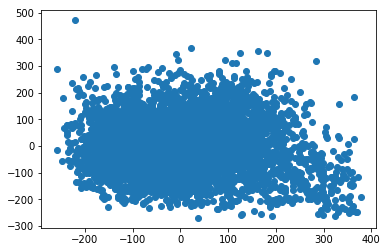

In [38]:
print(X_r.shape)

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.show()

In [39]:
data = [
    go.Scatter3d(
        x=X_r[:, 0],
        y=X_r[:, 1],
        z=X_r[:, 2],
        mode='markers',
        marker=dict(
            size=2
        ))
]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
py.plot(fig)

'file://C:\\Users\\yosef\\Desktop\\Project\\DM_pro_local\\cnn\\temp-plot.html'

# Convolutional Neural Network

In [40]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

In [41]:
num_classes = 15000

In [42]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(256, 256, 1)))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D((2, 2),padding='same'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn.add(LeakyReLU(alpha=0.1))                  
cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn.add(Dropout(0.4))
cnn.add(Flatten())
cnn.add(Dense(256, activation='linear'))
cnn.add(LeakyReLU(alpha=0.1))           
cnn.add(Dropout(0.3))
cnn.add(Dense(num_classes, activation='softmax'))

In [43]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.SGD(),
            metrics=['accuracy'])

In [45]:
print(X_train.shape)

(6666, 65536)


In [44]:
X_train_cnn = X_train.reshape(1000, 256, 256, 1)
X_test_cnn = X_test.reshape(1000, 256, 256, 1)

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


ValueError: cannot reshape array of size 436862976 into shape (3000,256,256,1)

In [ ]:
print(X_train_cnn.shape)
print(X_test_cnn.shape)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

In [29]:
dropout = cnn.fit(X_train_cnn, y_train_one_hot,
                  batch_size=64, epochs=20, verbose=1,
                  validation_data=(X_test_cnn, y_test_one_hot))

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 793s 264ms/step - loss: 9.3984 - acc: 0.0357 - val_loss: 9.1447 - val_acc: 0.0410
Epoch 2/20
 128/3000 [>.............................] - ETA: 13:01 - loss: 8.6901 - acc: 0.0547

KeyboardInterrupt: 